In [2]:
!pip install konlpy

In [3]:
from konlpy.tag import Okt
okt = Okt()
print("Okt 형태소 분석:", okt.morphs("한국어 단어는 형태소들로 구성되어 있다."))
print("Okt 품사 태깅:", okt.pos("한국어 단어는 형태소들로 구성되어 있다."))

Okt 형태소 분석: ['한국어', '단어', '는', '형태소', '들', '로', '구성', '되어', '있다', '.']
Okt 품사 태깅: [('한국어', 'Noun'), ('단어', 'Noun'), ('는', 'Josa'), ('형태소', 'Noun'), ('들', 'Suffix'), ('로', 'Josa'), ('구성', 'Noun'), ('되어', 'Verb'), ('있다', 'Adjective'), ('.', 'Punctuation')]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7db8ad80ed10>)

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [7]:
print("Train data len:", len(train_data))
train_data[:5]

Train data len: 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
print("Test data len:", len(test_data))
test_data[:5]

Test data len: 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [9]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data.groupby('label').size()

label
0    73342
1    72841
dtype: int64

In [10]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data[:5]

<ipython-input-10-d1c17dc31982>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [11]:
train_data['document'] = train_data['document'].str.replace("^ +", "")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-11-9751ec4f9f15>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("^ +", "")


id            0
document    790
label         0
dtype: int64


In [12]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [13]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145393


In [14]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [15]:
okt = Okt()
X_train = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_train.append(stopwords_removed_sentence)
print(X_train[:3])

100%|██████████| 145393/145393 [11:32<00:00, 209.86it/s]

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [16]:
X_test = []
for sentence in tqdm(test_data['document']):
  tokenized_sentence = okt.morphs(str(sentence), stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_test.append(stopwords_removed_sentence)

100%|██████████| 50000/50000 [04:05<00:00, 203.26it/s]


In [17]:
def tockenize(x_train, y_train, x_val, y_val):
  word_list = []
  for sent in x_train:
    for word in sent:
      word_list.append(word)

  corpus = Counter(word_list)
  corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:10000]
  onehot_dict = {w: i+1 for i,w in enumerate(corpus_)}

  final_list_train, final_list_test = [], []
  for sent in x_train:
    final_list_train.append([onehot_dict[word] for word in sent if word in onehot_dict.keys()])
  for sent in x_val:
    final_list_test.append([onehot_dict[word] for word in sent if word in onehot_dict.keys()])

  return np.array(final_list_train), np.array(y_train), np.array(final_list_test), np.array(y_val), onehot_dict

In [18]:
x_train, y_train, x_test, y_test, vocab = tockenize(X_train, train_data['label'], X_test, test_data['label'])

<ipython-input-17-ca01c7012b51>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(y_train), np.array(final_list_test), np.array(y_val), onehot_dict


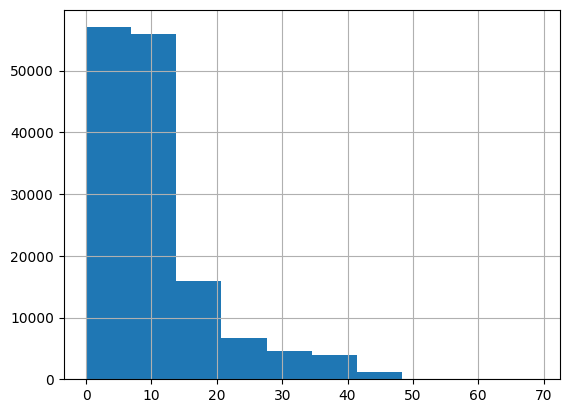

count    145393.000000
mean         10.495492
std           8.661166
min           0.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          69.000000
dtype: float64

In [19]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [20]:
def padding_(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len), dtype=int)
  for ii, review in enumerate(sentences):
    if len(review) != 0:
      features[ii, -len(review):] = np.array(review)[:seq_len]
  return features

x_train_pad = padding_(x_train, 50)
x_test_pad = padding_(x_test, 50)

In [21]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [22]:
class GRU_model(nn.Module):
  def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, device):
    super(GRU_model, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.device = device

    self.embed = nn.Embedding(n_vocab, embed_dim)
    self.gru = nn.GRU(embed_dim, self.hidden_dim,
                      num_layers=self.n_layers,
                      batch_first=True)
    self.out = nn.Linear(self.hidden_dim, n_classes)

  def forward(self, x):
    x = self.embed(x)
    h_0 = self._init_state(batch_size=x.size(0))
    x,_ = self.gru(x,h_0)
    h_t = x[:, -1, :]
    logit = self.out(h_t)
    return logit

  def _init_state(self, batch_size):
    new_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
    return new_state

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, device):
    super().__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.device = device

    self.embed = nn.Embedding(n_vocab, embed_dim)
    self.lstm = nn.LSTM(embed_dim, self.hidden_dim,
                        num_layers=self.n_layers,
                        batch_first=True)
    self.out = nn.Linear(self.hidden_dim, n_classes)

  def forward(self,x):
    x = self.embed(x)
    h_0 = self._init_state(batch_size=x.size(0))
    x,_ = self.lstm(x, h_0)
    h_t = x[:,-1,:]
    logit = self.out(h_t)
    return logit

  def _init_state(self, batch_size):
    new_cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device)
    new_hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device)
    return (new_hidden_state, new_cell_state)

In [23]:
is_cuda = torch.cuda.is_available()
if is_cuda:
  device = torch.device("cuda")
  print("GPU is available")
else:
  device = torch.device("cpu")
  print("CPU used")

GPU is available


In [24]:
n_layers = 1
vocab_size = len(vocab) + 1
hidden_dim = 128
embed_dim = 100
n_classes = 2

model = GRU_model(n_layers, hidden_dim, vocab_size, embed_dim, n_classes, device).to(device)

In [26]:
def train(model, criterion, optimizer, data_loader):
  model.train()
  train_loss = 0
  for i, (x, y)  in enumerate(data_loader):
    x, y = x.to(device), y.to(device)

    logit = model(x)
    loss = criterion(logit, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * x.size(0)

  return train_loss / len(data_loader.dataset)

In [27]:
def evaluate(model, data_loader):
  model.eval()
  corrects, total_loss = 0, 0
  for i, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)

    logit = model(x)
    corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
  size = len(data_loader.dataset)

  avg_accuracy = 100 * corrects / size
  return avg_accuracy

In [29]:
num_epochs = 10
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for e in range(1, num_epochs+1):
  train_loss = train(model, criterion, optimizer, train_loader)
  test_accuracy = evaluate(model, test_loader)

  print("[Epoch: %d] train loss : %5.2f | test accuracy : %5.2f" % (e, train_loss, test_accuracy))

[Epoch: 1] train loss :  0.41 | test accuracy : 83.68
[Epoch: 2] train loss :  0.32 | test accuracy : 84.11
[Epoch: 3] train loss :  0.27 | test accuracy : 84.57
[Epoch: 4] train loss :  0.22 | test accuracy : 84.60
[Epoch: 5] train loss :  0.16 | test accuracy : 84.10
[Epoch: 6] train loss :  0.12 | test accuracy : 83.57
[Epoch: 7] train loss :  0.09 | test accuracy : 83.28
[Epoch: 8] train loss :  0.07 | test accuracy : 83.15
[Epoch: 9] train loss :  0.06 | test accuracy : 82.96
[Epoch: 10] train loss :  0.05 | test accuracy : 83.09
